# Lab 04: Image Matching and Image Stitching

In this lab, you'll implement and play with the algorithms taught in course 5 and 6. 

- Student Name: 李瀚轩
- Student ID: 3220106039
- Date: 2023-11-7

---

## Part I: Image Matching

### Task 1: Find corners with harris detector

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
c:\Users\petrichor0\anaconda3\envs\cv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


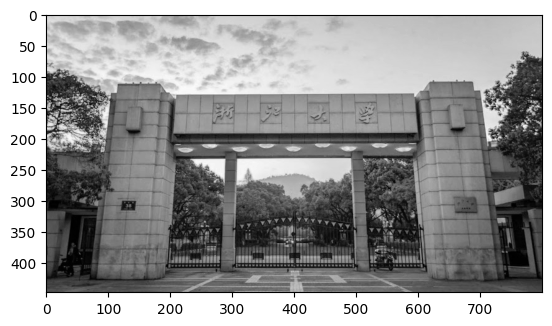

In [38]:
# Let's load an example image
# filename = 'building.jpeg'
# img = cv2.imread(filename)
# img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# fig = plt.imshow(img, cmap='gray')

Step 1. Compute the covariance matrix at each point

$$H=\sum_{(u,v)}w(u,v)\begin{bmatrix}I_x^2& I_xI_y\\I_xI_y &I_y^2\end{bmatrix}$$

where $I_x=\frac{\partial f}{\partial x}, I_y=\frac{\partial f}{\partial y}$, $\sum_{(u,v)}w(u,v)$ means gaussian at each map .


In [2]:
# normalize image to [0,1]
def Harris(img):
    h,w=img.shape
    # use sobel operator at every location
    grad=np.zeros((h,w,2),dtype=np.float32)
    grad[:,:,0]=cv2.Sobel(img,cv2.CV_16S,1,0,ksize=3)
    grad[:,:,1]=cv2.Sobel(img,cv2.CV_16S,0,1,ksize=3)

    # gaussian weights, what window-size should be used?
    gray=cv2.GaussianBlur(img,ksize=(3,3),sigmaX=2)
    # compute H 
    m=np.zeros((h,w,3),dtype=np.float32)
    m[:,:,0]=grad[:,:,0]**2
    m[:,:,1]=grad[:,:,1]**2
    m[:,:,2]=grad[:,:,0]*grad[:,:,1]
    m[:,:,0] = cv2.GaussianBlur(m[:,:,0],ksize=(3,3),sigmaX=2)    
    m[:,:,1] = cv2.GaussianBlur(m[:,:,1],ksize=(3,3),sigmaX=2)
    m[:,:,2] = cv2.GaussianBlur(m[:,:,2],ksize=(3,3),sigmaX=2)    
    m = [np.array([[m[i,j,0],m[i,j,2]],[m[i,j,2],m[i,j,1]]]) for i in range(h) for j in range(w)]
    # compute harris response
    D,T=list(map(np.linalg.det,m)),list(map(np.trace,m))
    f = np.array([d-0.01*t for d,t in zip(D,T)])
    # threshold and visualize the response map
    f_max=np.max(f)
    f=f.reshape(h,w)
    corner=np.zeros_like(f,dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if f[i,j]>f_max*0.01:
                corner[i,j]=255
    return corner

Step 2. Harris response

Theoretically, we can compute eigenvalues

$H=\begin{bmatrix}a&b\\c&d\end{bmatrix}\quad \lambda_\pm=\frac{1}{2}((a+d)\pm\sqrt{4bc+(a-d)^2})$

and then classify points using eigenvalues of H, like:

<img src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/harris_region.jpg" alt="drawing" width="200"/>

However, computing eigenvalues are expensive, so we use the following alternative:

$$f=\frac{\lambda_1 \lambda_2}{\lambda_1+\lambda_2}=\frac{determinant(H)}{trace(H)}$$

where $det(\begin{bmatrix}a&b\\c&d\end{bmatrix})=ad-bc$,   and $trace(\begin{bmatrix}a&b\\c&d\end{bmatrix})=a+d$

In [55]:
# compute harris response




Step 3. Threshold $f$ and visualize

we skip non-maximum suppression operation here. You only need to visualize the thresholded harris response map.

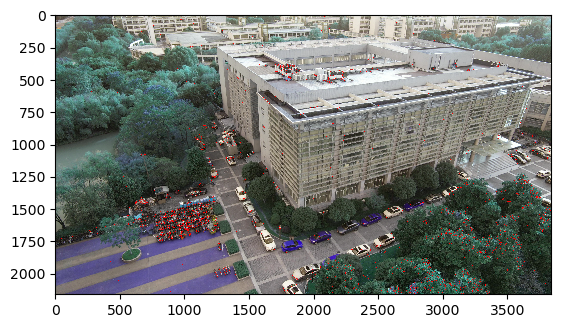

In [4]:
# threshold and visualize the response map

img=cv2.imread('00001.jpg')
gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
dst=Harris(gray)
img[dst>0.01*dst.max()]=[255,0,0]
fig=plt.imshow(img)


Further reading:

[【计算机视觉】2. 特征点检测：Harris, SIFT, SURF, ORB](https://zhuanlan.zhihu.com/p/36382429)

### Task 2: SIFT

To do this task, read [opencv documentation on SIFT](https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html) first, and use it for local feature detection and description.

In [6]:
# load an image
img0 = cv2.imread("1.jpeg")
img1 = cv2.imread("2.jpeg")

In [7]:
# creat sift extractor (detector + descriptor)
SIFT = cv2.SIFT_create()

# get the detector and descriptor
kpts0, descs0 = SIFT.detectAndCompute(img0,None)
kpts1, descs1 = SIFT.detectAndCompute(img1,None)

For SIFT descriptors, people usually match them with ratio-test.

(1) Please list the main advantage of ratio-test in matching SIFT descriptors.

(2) Do you think mutual-nearest-neighbor method can also work?

  (1)Improve the robustness of the matching process by ensuring the best match found is better than the second-best one.
  
  (2) I think it can also work. By using mutual-nearest-neighbour method, a match is considered valid only if a keypoint in one image is the nearest neighbout of its counterpart in another image, which can eliminate mismatches.

In [8]:
# compute descriptor distance
bf = cv2.BFMatcher()
matches=bf.knnMatch(descs0,descs1,k=2)
good_matches=[]
for m,n in matches:
    if m.distance<0.75*n.distance:
        good_matches.append(m)

# ratio test
mkpts0 = np.float32([kpts0[m.queryIdx].pt for m in good_matches])
mkpts1 = np.float32([kpts1[m.trainIdx].pt for m in good_matches])

And visualize the final matches.

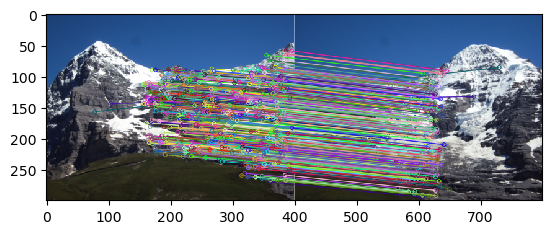

In [11]:
# visualization
# from utils import make_matching_figure
# fig = make_matching_figure(img0, img1, mkpts0, mkpts1,None,None, kpts1, text=[], dpi=75) # You might need to read the documentation of this function. Or you can write your own drawing function.

# I wirte my own visualization function as follows:
img_matches = cv2.drawMatches(img0, kpts0, img1, kpts1, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
plt.imshow(img_matches_rgb)
plt.show()

---

## Part II: Image Stitching

One application fo image matching is to stitch multiple images and get one panorama.

### Task 3: Transformation

Considering 2 images as input, you can use SIFT (provided by cv2) to find the transformation between them (implement it on your own).

In [12]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# load images
img0_rgb = cv2.imread("1.jpeg", cv2.IMREAD_COLOR)[..., [2,1,0]]
img1_rgb = cv2.imread("2.jpeg", cv2.IMREAD_COLOR)[..., [2,1,0]]
img0_gray = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

In [14]:
# compute SIFT keypoints and descriptors
# note: on gray image
SIFT = cv2.SIFT_create()
kpts0, descs0 = SIFT.detectAndCompute(img0_gray,None)
kpts1, descs1 = SIFT.detectAndCompute(img1_gray,None)
# find matches
bf = cv2.BFMatcher()
matches=bf.knnMatch(descs0,descs1,k=2)
good_matches=[]
for m,n in matches:
    if m.distance<0.75*n.distance:
        good_matches.append(m)

# ratio test
mkpts0 = np.float32([kpts0[m.queryIdx].pt for m in good_matches])
mkpts1 = np.float32([kpts1[m.trainIdx].pt for m in good_matches])

Here, the transformation $H$ is defined as 
$$\begin{bmatrix}x_0\\y_0\\1\end{bmatrix}=\begin{bmatrix}h_{11}&h_{12}&h_{13}\\h_{21}&h_{22}&h_{23}\\0&0&1\end{bmatrix}\begin{bmatrix}x_1\\y_1\\1\end{bmatrix}$$

Please answer:

(1) What type is this transformation?

(2) Please write down the converted equation in the form of $Ah=b$. To solve this equation, what's the minimal number of matches that we need? 

(1) It is an affine transformation.

(2) From the equation given above(I consider the more general matrix, i.e homography matrix whose $h_{31},h_{32}$ can be nonzero),we have:

$\begin{bmatrix}x_i&y_i&1&0&0&0&-x_{i}^{'}x_i&-x^{'}y_i&-x_i^{'}\\0&0&0&x_i&y_i&1&-y_i^{'}x_i&-y_i^{'}y_i&-y_i^{'}\end{bmatrix}\begin{bmatrix}h_{00}\\h_{01}\\h_{02}\\h_{10}\\h_{11}\\h_{12}\\h_{20}\\h_{21}\\h_{22}\end{bmatrix}=\begin{bmatrix}0\\0\end{bmatrix}$

since the freedom of the $H$ matrix is 8, so the minimal number of matched we need is 4 pairs.

In [15]:
# randomly select K matches (according to your answer)
import random
K=4
random_selected_matches = random.sample(good_matches, K)
selected_mkpts0 = np.float32([kpts0[m.queryIdx].pt for m in random_selected_matches])
selected_mkpts1 = np.float32([kpts1[m.trainIdx].pt for m in random_selected_matches])

# solve the equation with np.linalg.solve(A,0)
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html
A = []
for i in range(K):
    x, y = selected_mkpts0[i]
    xp, yp = selected_mkpts1[i]
    A.append([-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp])
    A.append([0, 0, 0, -x, -y, -1, x * yp, y * yp, yp])
A = np.array(A)
print(A)
_, _, V = np.linalg.svd(A)
H = V[-1, :].reshape(3, 3)
print(H)

[[-2.50308884e+02 -1.69985703e+02 -1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.51824766e+04  1.71015137e+04
   1.00605606e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.50308884e+02
  -1.69985703e+02 -1.00000000e+00  4.79910547e+04  3.25909043e+04
   1.91727325e+02]
 [-3.26401184e+02 -1.43030121e+02 -1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.77324023e+04  2.52985371e+04
   1.76875595e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.26401184e+02
  -1.43030121e+02 -1.00000000e+00  5.48757227e+04  2.40467305e+04
   1.68123535e+02]
 [-3.45342438e+02 -1.45039154e+02 -1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  6.72603438e+04  2.82484355e+04
   1.94764206e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.45342438e+02
  -1.45039154e+02 -1.00000000e+00  5.90617070e+04  2.48051191e+04
   1.71023605e+02]
 [-1.92524597e+02 -2.10211197e+02 -1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.0000000

### Task 4: RANSAC

To use naive ransac algorithm, we need $N$ sample-points(样本点), to solve the model, we need $K$ sample-points as a minimal requirement. Then perform:

1. Randomly sample $K$ sample-points.
2. Fit the model with $K$ sample-points. Denoted as $\hat h$.
3. Compute error of other sample points according to $\hat h$. Count the inliers within some threshold.
4. Repeat $M$ times, the final $h$ is the $\hat h$ with most inliers. 

In [16]:
# implement your own RANSAC
def ransac_to_estimate_H(good_matches, K, inlier_thr, M):
    best_h=None
    best_inliers=0
    for _ in range(M):
        random_selected_matches = random.sample(good_matches, K)
        selected_mkpts0 = np.float32([kpts0[m.queryIdx].pt for m in random_selected_matches])
        selected_mkpts1 = np.float32([kpts1[m.trainIdx].pt for m in random_selected_matches])
        A = []
        for i in range(K):
            x, y = selected_mkpts0[i]
            xp, yp = selected_mkpts1[i]
            A.append([-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp])
            A.append([0, 0, 0, -x, -y, -1, x * yp, y * yp, yp])

        A = np.array(A)
        _, _, V = np.linalg.svd(A)
        H = V[-1, :].reshape(3, 3)
        point0=np.float32([kpts0[m.queryIdx].pt for m in good_matches])
        point1=np.float32([kpts1[m.trainIdx].pt for m in good_matches])
        inliners=0
        for i in range(506):
            x,y=point0[i]
            xp,yp=point1[i]
            projected_point=H@np.array([x,y,1])
            projected_point=projected_point/projected_point[2]
            error=np.sqrt((projected_point[0]-xp)**2+(projected_point[1]-yp)**2)
            if error<inlier_thr:
                inliners = inliners+1
        if inliners>best_inliers:
            best_h=H
            best_inliers=inliners
    return best_h


H = ransac_to_estimate_H(good_matches,K=4,inlier_thr=0.05,M=1000)
print(H)

[[-6.89467637e-03  3.75985905e-04  9.99675753e-01]
 [-6.84141957e-04 -6.55752698e-03  2.28014549e-02]
 [-2.20723507e-06  4.46798556e-07 -6.11034844e-03]]


In [29]:
h,w=img1_rgb.shape[:2]
img0r=cv2.warpPerspective(img0_rgb,H,(w*2,h))
pano1 = img0r.copy()
pano1[0:img1_rgb.shape[0],0:img1_rgb.shape[1]]=img1_rgb
pano1=cv2.cvtColor(pano1,cv2.COLOR_RGB2BGR)
cv2.imshow(' ',pano1)
cv2.waitKey(0)
cv2.destroyAllWindows()

How to solve the artifacts in the overlapping region? Name 2 possible methods.

- Blending(blurring): we can blend the intensities based on gradient using linear of gaussian.
- Modify the pixel values in the overlapping region.
- Like we did in lec3 when resizing images, we can find a path where gradients change the least, and applying interoplotion.